# Определение пола владельца HTTP cookie по истории активности пользователя в интернете

Необходимо по цифровым следам пользователя (на каких сайтах  он сидел, сколько раз заходил, какое у него устройство и тд) определить его пол. Данные взяты с соревнований MTS ML CUP (https://ods.ai/competitions/mtsmlcup).

Описание колонок файла с данными:

- 'region_name' – Регион

- 'city_name' – Населенный пункт

- 'cpe_manufacturer_name' – Производитель устройства

- 'cpe_model_name' – Модель устройства

- 'url_host' – Домен, с которого пришел рекламный запрос

- 'cpe_model_os_type' – Операционка на устройстве

- 'price' – Оценка цены устройства

- 'date' – Дата

- 'part_of_day' – Время дня (утро, вечер, итд)

- 'request_cnt' – Число запросов одного пользователя за время дня (поле part_of_day)

- 'user_id' – ID пользователя

Таргет:

- 'is_male' – Признак пользователя : мужчина (1-Да, 0-Нет)



In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, log_loss

from lightgbm import LGBMClassifier

from umap import UMAP

import optuna

import yaml
import joblib

from typing import Dict

import warnings
warnings.filterwarnings("ignore");

PATH = '/Users/michael/Documents/PyMagic/MTS ML Cup/'
RAND = 42

pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

Прочтем конфигурационный файл

In [2]:
config_path = 'Pet Project 2/config/params.yml'
config = yaml.load(open(config_path), Loader=yaml.FullLoader)

preprocessing = config['preprocessing']
train = config['train']

# Предварительный просмотр данных

Прочтем файл с данными

In [3]:
df = pd.read_csv(preprocessing['data_path'])
df.head()

,region_name,city_name,cpe_manufacturer_name,cpe_model_name,url_host,cpe_model_os_type,price,date,part_of_day,request_cnt,user_id,is_male
0,Краснодарский край,Геленджик,Apple,iPhone X,instagram.com,iOS,67590.0,2021-06-29,day,2,214519,0
1,Краснодарский край,Геленджик,Apple,iPhone X,instagram.com,iOS,67590.0,2021-06-29,evening,6,214519,0
2,Краснодарский край,Геленджик,Apple,iPhone X,googleads.g.doubleclick.net,iOS,76665.0,2021-07-19,day,3,60193,1
3,Краснодарский край,Геленджик,Apple,iPhone X,vk.com,iOS,73374.0,2021-07-28,day,1,319852,0
4,Краснодарский край,Геленджик,Apple,iPhone X,tpc.googlesyndication.com,iOS,73374.0,2021-07-24,morning,1,319852,0


Типы данных для каждого столбца

In [4]:
df.dtypes

region_name               object
city_name                 object
cpe_manufacturer_name     object
cpe_model_name            object
url_host                  object
cpe_model_os_type         object
price                    float64
date                      object
part_of_day               object
request_cnt                int64
user_id                    int64
is_male                    int64
dtype: object

Количество пропусков по столбцам

In [5]:
df.isna().sum()

region_name              0
city_name                0
cpe_manufacturer_name    0
cpe_model_name           0
url_host                 0
cpe_model_os_type        0
price                    0
date                     0
part_of_day              0
request_cnt              0
user_id                  0
is_male                  0
dtype: int64

Описание числовых признаков

In [6]:
df.describe()

,price,request_cnt,user_id,is_male
count,172797.000000,172797.000000,172797.000000,172797.000000
mean,35025.938194,1.728711,205589.040747,0.516473
std,26485.140735,1.215745,119226.875755,0.499730
min,90.000000,1.000000,4.000000,0.000000
25%,14768.000000,1.000000,102661.000000,0.000000
50%,23966.000000,1.000000,206255.000000,1.000000
75%,52288.000000,2.000000,309647.000000,1.000000
max,140990.000000,12.000000,415157.000000,1.000000


Описание категориальных признаков

In [7]:
df.describe(include='object')

,region_name,city_name,cpe_manufacturer_name,cpe_model_name,url_host,cpe_model_os_type,date,part_of_day
count,172797,172797,172797,172797,172797,172797,172797,172797
unique,69,148,6,136,4887,2,369,4
top,Москва,Москва,Apple,iPhone 11,googleads.g.doubleclick.net,Android,2021-06-16,day
freq,27648,27648,73402,17031,11442,99395,3695,57480


Количество явных дубликатов

In [8]:
df.duplicated().sum()

0

# EDA

## Таргет

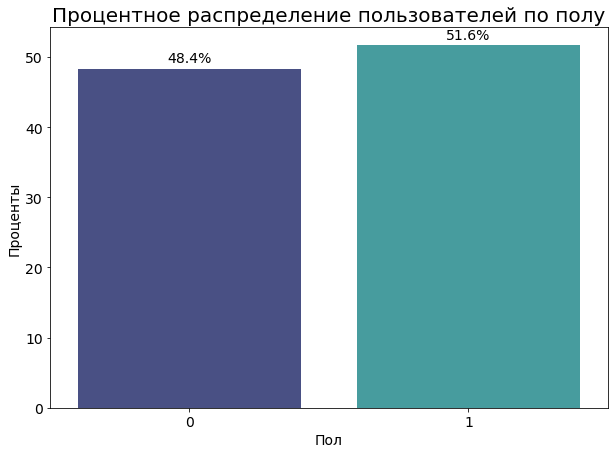

In [9]:
gender_values = (df.is_male
                   .value_counts(normalize=True)
                   .mul(100)
                   .rename('percent')
                   .reset_index()) 

fig = plt.figure(figsize=(10, 7))

ax = sns.barplot(x='index',
                 y='percent',
                 data=gender_values,
                 palette='mako')

for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    ax.annotate(percentage, 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', 
                va='center',
                xytext=(0, 10),
                textcoords='offset points',
                fontsize=14)
    
plt.title('Процентное распределение пользователей по полу', fontsize=20)

plt.xlabel('Пол', fontsize=14)
plt.ylabel('Проценты', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

**Вывод:** дисбаланса классов не наблюдается

## Влияние различных признаков на целевую переменную

### Время дня

Создадим функцию для построения вспомогательной сводной таблицы для построения требуемого графика

In [10]:
def pivot(column: str) -> pd.DataFrame:
    pivot = df.pivot_table(index=['is_male',column],
                           values='user_id',
                           aggfunc='count').reset_index()
    pivot_1 = pivot.groupby('is_male').sum('user_id').reset_index().rename(columns={'user_id': 'sum_gender'})
    pivot = pivot.merge(pivot_1, on='is_male')
    pivot['percent'] = (pivot['user_id'] / pivot['sum_gender']) * 100
    
    return pivot.sort_values('percent', ascending=False)

Построим график

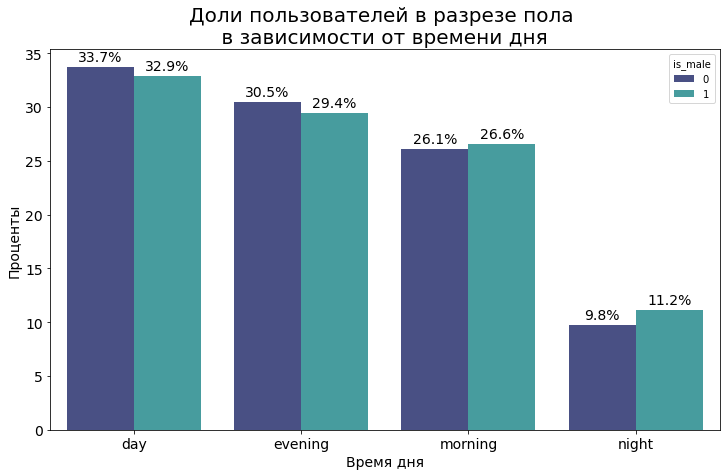

In [11]:
fig = plt.figure(figsize=(12,7))

ax = sns.barplot(x='part_of_day',
                 y='percent',
                 data=pivot('part_of_day'),
                 palette='mako',
                 hue='is_male')

for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    ax.annotate(percentage, 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', 
                va='center',
                xytext=(0, 10),
                textcoords='offset points', 
                fontsize=14)
    
plt.title('Доли пользователей в разрезе пола \n в зависимости от времени дня ', fontsize=20)

plt.xlabel('Время дня', fontsize=14)
plt.ylabel('Проценты', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);


**Вывод:** Чаще всего пользователи выходят в сеть днем, чуть реже вечером и утром. Ночью, как правило, люди спят, отсюда и небольшое число пользователей, выходивших в сеть в сравнении с отсальными временами дня. Стоит отметить, что днем и вечером чаще выходят в сеть женщины, а утром и ночью мужчины.

### Производитель устройства

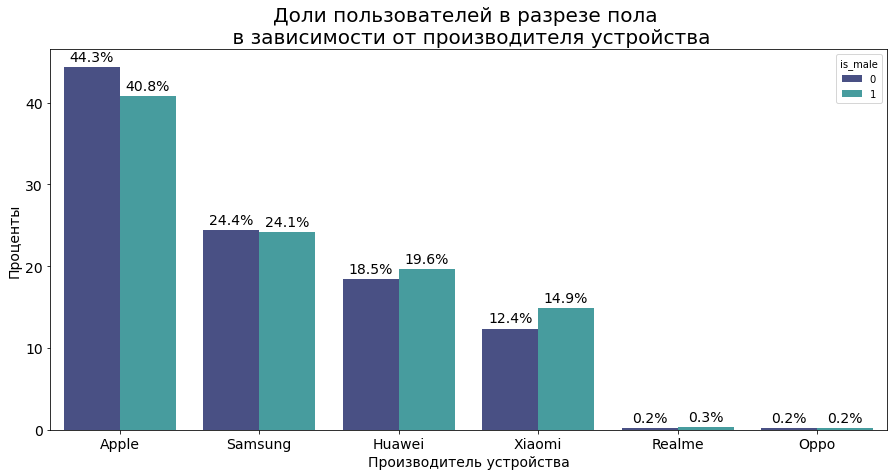

In [12]:
fig = plt.figure(figsize=(15,7))

ax = sns.barplot(x='cpe_manufacturer_name',
                 y='percent',
                 data=pivot('cpe_manufacturer_name'),
                 palette='mako',
                 hue='is_male')

for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    ax.annotate(percentage, 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', 
                va='center',
                xytext=(0, 10),
                textcoords='offset points', 
                fontsize=14)
    
plt.title('Доли пользователей в разрезе пола \n в зависимости от производителя устройства', fontsize=20)

plt.xlabel('Производитель устройства', fontsize=14)
plt.ylabel('Проценты', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

**Вывод:** Лидирующим брендом по количеству пользователей является Apple. Дальше идут Samsung, Huawei и Xiaomi. Пользователей с устройствами других производителей значительно меньше. При этом среди пользователей Apple и Samsung больше женщин, а среди пользователей остальных производителей больше мужчин.

### Операционная система на устройстве

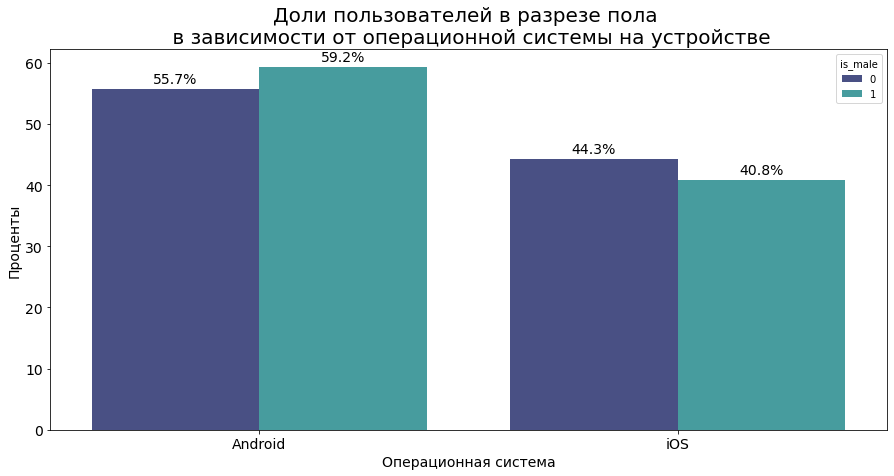

In [13]:
fig = plt.figure(figsize=(15,7))

ax = sns.barplot(x='cpe_model_os_type',
                 y='percent',
                 data=pivot('cpe_model_os_type'),
                 palette='mako',
                 hue='is_male')

for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    ax.annotate(percentage, 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', 
                va='center',
                xytext=(0, 10),
                textcoords='offset points', 
                fontsize=14)
    
plt.title('Доли пользователей в разрезе пола \n в зависимости от операционной системы на устройстве', fontsize=20)

plt.xlabel('Операционная система', fontsize=14)
plt.ylabel('Проценты', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

**Вывод:** Процент пользователей Android больше, чем у iOS (пользователей Apple больше, чем у других производителей по отдельности, но не в сумме). При этом Android больше предпочитают мужчины, а iOS женщины.

### Оценка цены устройства

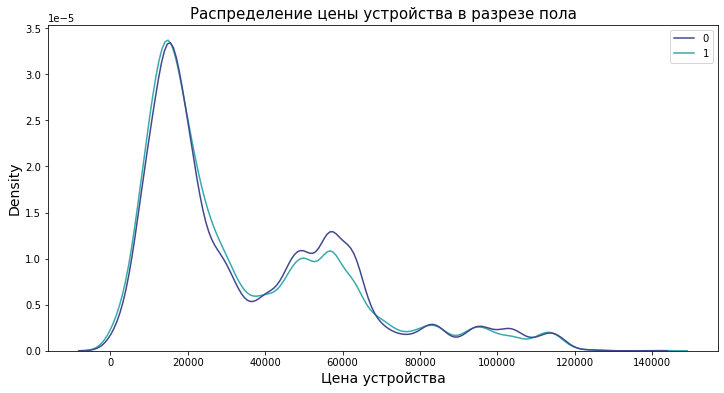

In [14]:
fig = plt.figure(figsize=(12,6))

sns.kdeplot(data={
                  '0': df[df.is_male==0].price,
                  '1': df[df.is_male==1].price,
            },
            common_norm=False,
            palette='mako')

plt.title('Распределение цены устройства в разрезе пола', fontsize=15)

plt.xlabel('Цена устройства', fontsize=14)
plt.ylabel('Density', fontsize=14);

**Вывод:** характеры распределений цены устройства в разрезе пола практически идентичны

# Подготовка данных для моделирования

Функция для сохранения уникальных значений признаков (для FrontEnd части, чтобы можно было потом эти значения подавать на вход модели)

In [15]:
def save_unique_train_data(
    data: pd.DataFrame, drop_columns: list, target_column: str, unique_values_path: str
) -> None:
    """
    Сохранение словаря с признаками и уникальными значениями
    :param drop_columns: список с признаками для удаления
    :param data: датасет
    :param target_column: целевая переменная
    :param unique_values_path: путь до файла со словарем
    :return: None
    """
    unique_df = data.drop(
        columns=drop_columns+[target_column], axis=1, errors="ignore"
    )
    # создаем словарь с уникальными значениями для вывода в UI
    dict_unique = {key: unique_df[key].unique().tolist() for key in unique_df.columns}
    with open(unique_values_path, "w") as file:
        json.dump(dict_unique, file, ensure_ascii=False)

In [16]:
save_unique_train_data(
    data=df,
    drop_columns=preprocessing["drop_for_unique"],
    target_column=train["target_column"],
    unique_values_path=preprocessing["unique_values_path"],
)

# Training

## Baseline

Удалим ненужные колонки

In [17]:
df = df.drop(preprocessing['drop_columns'], axis=1)

Преобразуем категориальные типы колонок из object в category для подачи в LightGBM

In [18]:
def transform_types(data: pd.DataFrame, change_type_columns: dict) -> pd.DataFrame:
    """
    Преобразование признаков в заданный тип данных
    :param data: датасет
    :param change_type_columns: словарь с признаками и типами данных
    :return:
    """
    return data.astype(change_type_columns, errors="raise")

In [19]:
df = transform_types(data=df, change_type_columns=preprocessing['change_type_columns'])

Теперь разобьем данные на обучающую и тестовую выборки

In [20]:
X = df.drop([train['target_column']], axis=1)
y = df[train['target_column']]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=train['test_size'],
                                                    shuffle=True,
                                                    stratify=y,
                                                    random_state=train['random_state'])

X_train_, X_val, y_train_, y_val = train_test_split(X_train,
                                                    y_train,
                                                    test_size=train['val_size'],
                                                    shuffle=True,
                                                    stratify=y_train,
                                                    random_state=train['random_state'])

eval_set = [(X_val, y_val)]

Обучим модель

In [21]:
lgb = LGBMClassifier(random_state=train['random_state'])

lgb.fit(X_train_,
        y_train_,
        eval_metric=train['eval_metric'],
        eval_set=eval_set,
        verbose=False,
        early_stopping_rounds=train['early_stopping_rounds']);

Функция для вывода метрик

In [22]:
def get_metrics(y_test: np.array, y_pred: np.array, y_proba: np.array) -> Dict:
    dict_metrics = {
        'roc_auc': round(roc_auc_score(y_test, y_proba[:, 1]), 3),
        'precision': round(precision_score(y_test, y_pred), 3),
        'recall': round(recall_score(y_test, y_pred), 3),
        'f1': round(f1_score(y_test, y_pred), 3),
        'logloss': round(log_loss(y_test, y_proba), 3)
    }

    return dict_metrics

Сделаем предикт и посмотрим на метрики

In [23]:
y_pred = lgb.predict(X_test)
y_pred_proba = lgb.predict_proba(X_test)

result = get_metrics(y_test, y_pred, y_pred_proba)

print('roc-auc:', result['roc_auc'])
print('precision:', result['precision'])
print('recall:', result['recall'])
print('f1:', result['f1'])
print('logloss:', result['logloss'])

roc-auc: 0.862
precision: 0.775
recall: 0.792
f1: 0.783
logloss: 0.489


## Tuning

Подберем опитмальные значения гиперпараметров с помощью optuna

In [24]:
# целевая функция
def objective_lgb(trial, X, y, N_FOLDS, random_state):
    lgb_params = {
#         "n_estimators": trial.suggest_categorical("n_estimators", [1000, 1200, 1300, 1500, 1700, 2000, 2300]),
        "n_estimators": trial.suggest_categorical("n_estimators", [2300]),
#         "learning_rate": trial.suggest_float("learning_rate",
#                                              0.001,
#                                              0.3),
        "learning_rate": trial.suggest_categorical("learning_rate", [0.17865787263309982]),
        "num_leaves": trial.suggest_int("num_leaves", 15, 40, step=5),
        "min_child_samples": trial.suggest_int("min_child_samples", 15, 40, step=5),
        "objective": trial.suggest_categorical("objective", ["binary"]),
        "random_state": trial.suggest_categorical("random_state", [random_state])
    }

    cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=random_state)

    cv_predicts = np.empty(N_FOLDS)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        pruning_callback = optuna.integration.LightGBMPruningCallback(
            trial, "auc")
        model = LGBMClassifier(**lgb_params)
        model.fit(X_train,
                  y_train,
                  eval_set=[(X_test, y_test)],
                  eval_metric="auc",
                  early_stopping_rounds=100,
                  callbacks=[pruning_callback],
                  verbose=0)

        probas = model.predict_proba(X_test)[:, 1]
        cv_predicts[idx] = roc_auc_score(y_test, probas)

    return np.mean(cv_predicts)

In [25]:
%%time
study = optuna.create_study(direction="maximize", study_name="LGB")
func = lambda trial: objective_lgb(
    trial, X_train, y_train, N_FOLDS=train['n_folds'], random_state=train['random_state'])
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(func, n_trials=train['n_trials'], show_progress_bar=True)

[I 2023-05-05 01:17:33,459] A new study created in memory with name: LGB



CPU times: user 24min 43s, sys: 2min 3s, total: 26min 47s
Wall time: 3min 24s


Лучшие значения параметров

In [26]:
study.best_params

{'n_estimators': 2300,
 'learning_rate': 0.17865787263309982,
 'num_leaves': 35,
 'min_child_samples': 15,
 'objective': 'binary',
 'random_state': 42}

In [27]:
best_params = train['params_path']

with open(best_params, 'w') as f:
    json.dump(study.best_params, f)

Обучим модель

In [28]:
%%time
lgb_tuned = LGBMClassifier(**study.best_params)

lgb_tuned.fit(X_train_,
              y_train_,
              eval_set=eval_set,
              verbose=False,
              early_stopping_rounds=train['early_stopping_rounds']);

CPU times: user 50.7 s, sys: 3.78 s, total: 54.4 s
Wall time: 7.06 s


LGBMClassifier(learning_rate=0.17865787263309982, min_child_samples=15,
               n_estimators=2300, num_leaves=35, objective='binary',
               random_state=42)

In [29]:
# save model
joblib.dump(lgb_tuned, train['model_path'])

['Pet Project 2/models/model_lgb.joblib']

Сделаем предикт и посмотрим на метрики

In [30]:
y_pred = lgb_tuned.predict(X_test)
y_pred_proba = lgb_tuned.predict_proba(X_test)

result = get_metrics(y_test, y_pred, y_pred_proba)

print('roc-auc:', result['roc_auc'])
print('precision:', result['precision'])
print('recall:', result['recall'])
print('f1:', result['f1'])
print('logloss:', result['logloss'])

roc-auc: 0.96
precision: 0.895
recall: 0.899
f1: 0.897
logloss: 0.258


In [31]:
metrics = get_metrics(y_test, lgb_tuned.predict(X_test), lgb_tuned.predict_proba(X_test))
with open(train['metrics_path'], 'w') as f:
    json.dump(metrics, f)